<p style="font-family: Arial; font-size:3.75em;color:blue; font-style:bold"><br>
Satellite Image Data Analysis</p>

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>Data Source: Landsat Satellite Image from National Land Cover Database</p>

Natural disasters such as hurricanes, floods and fires cause significant damage to residential homes. Example, Katrina (2005), Calgary floods (2013). In this notebook, we will analyze a sample satellite image dataset.


<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold">Loading the libraries we need: </p>

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import rasterio #accessing geospatial raster data
import rasterio.plot
import zipfile
from owslib.wms import WebMapService
import wget


<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold">Download data from MRLC: </p>

In [2]:
if not os.path.exists('./data'):
    os.makedirs('./data')

#download and unzip the NLCD 2011 conterminus US data set
url = 'https://prd-tnm.s3.amazonaws.com/StagedProducts/NLCD2011/Land_Cover/CONUS/nlcd_2011_landcover_2011_edition_2014_10_10.zip'
wget.download(url, './data/nlcd_2011.zip') 

path_to_zip_file = './data/nlcd_2011.zip'
directory_to_extract_to = './data/'
zip_ref = zipfile.ZipFile(path_to_zip_file, 'r')
zip_ref.extractall(directory_to_extract_to)
zip_ref.close()


100% [....................................................................] 1124715678 / 1124715678

In [3]:
#open file for reading
filepath = './data/nlcd_2011_landcover_2011_edition_2014_10_10/nlcd_2011_landcover_2011_edition_2014_10_10.img'
lc2011 = rasterio.open(filepath)

print(lc2011.profile)
print("")

print(type(lc2011))   #rasterio._io.RasterReader means that we have opened the file for reading.
print("Dimensions = ",lc2011.shape)   #size info
print("Coordinate reference system (proj4) = ",lc2011.crs)     #coordinate reference system
print("Data format = ",lc2011.driver) #data format
#print(lc2011.count) #number of bands
#took 10 minutes to run

{'driver': 'HFA', 'dtype': 'uint8', 'nodata': None, 'width': 161190, 'height': 104424, 'count': 1, 'crs': CRS({'proj': 'aea', 'lat_1': 29.5, 'lat_2': 45.5, 'lat_0': 23, 'lon_0': -96, 'x_0': 0, 'y_0': 0, 'ellps': 'GRS80', 'towgs84': '0,0,0,-0,-0,-0,0', 'units': 'm', 'no_defs': True}), 'transform': Affine(30.0, 0.0, -2493045.0,
       0.0, -30.0, 3310005.0), 'blockxsize': 64, 'blockysize': 64, 'tiled': True}

<class 'rasterio.io.DatasetReader'>
Dimensions =  (104424, 161190)
Coordinate reference system (proj4) =  +ellps=GRS80 +lat_0=23 +lat_1=29.5 +lat_2=45.5 +lon_0=-96 +no_defs +proj=aea +towgs84=0,0,0,-0,-0,-0,0 +units=m +x_0=0 +y_0=0
Data format =  HFA


<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold">Read the image file: </p>

In [4]:
dat = lc2011.read() #numpy array
print(type(dat))
#took 20 minutes to read

<class 'numpy.ndarray'>


In [5]:
print("Data type =",dat.dtype)
print("Data type =",dat.shape)

Data type = uint8
Data type = (1, 104424, 161190)


<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold">Clip image to ROI (Cambridge/Boston): </p>

In [6]:
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs

In [7]:
#Coordinates of Cambridge/Boston area in the Albers Equal Area (same as the Landsat data coordinate reference system (CRS)). 
#Picked the coordinates for Boston area using ArcGIS
minx, miny = 1990634, 2405090
maxx, maxy = 2032782, 2429800

bbox = box(minx, miny, maxx, maxy) #bounding box

#CRS code for Albers Equal Area from https://spatialreference.org/ref/sr-org/6630/proj4/
crs_code = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"

#Insert the bbox into a GeoDataFrame
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=crs_code)  #NAD83

#uncomment the line below to save the bounding box as a shape file
#geo.to_file('./nlcd_2011_landcover_2011_edition_2014_10_10/bbox.shp', driver='ESRI Shapefile')

#Re-project into the same coordinate system as the raster data if the bounding box is in a different CRS than the raster data
#geo = geo.to_crs(crs_code)



def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

coords = getFeatures(geo)

out_tif = "./data/nlcd_2011_landcover_2011_edition_2014_10_10/Clip.tif"
out_img, out_transform = mask(lc2011, shapes=coords, crop=True)

print("Size of original Landsat image =", dat.shape)
print("Size of clipped Landsat image =", out_img.shape)

# Update meta data with new clipped information
out_meta = lc2011.meta.copy()

print("Original meta data = ",out_meta)

out_meta.update({"driver": "HFA",
                 "dtype": "uint8",
                  "height": out_img.shape[1],
                  "width": out_img.shape[2],
                  "transform": out_transform,
                  "crs": crs_code})


with rasterio.open(out_tif, "w", **out_meta) as dest:
     dest.write(out_img)

print("New meta data with clipped information = ",out_meta)

Size of original Landsat image = (1, 104424, 161190)
Size of clipped Landsat image = (1, 824, 1405)
Original meta data =  {'driver': 'HFA', 'dtype': 'uint8', 'nodata': None, 'width': 161190, 'height': 104424, 'count': 1, 'crs': CRS({'proj': 'aea', 'lat_1': 29.5, 'lat_2': 45.5, 'lat_0': 23, 'lon_0': -96, 'x_0': 0, 'y_0': 0, 'ellps': 'GRS80', 'towgs84': '0,0,0,-0,-0,-0,0', 'units': 'm', 'no_defs': True}), 'transform': Affine(30.0, 0.0, -2493045.0,
       0.0, -30.0, 3310005.0)}
New meta data with clipped information =  {'driver': 'HFA', 'dtype': 'uint8', 'nodata': None, 'width': 1405, 'height': 824, 'count': 1, 'crs': '+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs', 'transform': Affine(30.0, 0.0, 1990605.0,
       0.0, -30.0, 2429805.0)}


<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold">Landsat landcover image of the Boston area: </p>

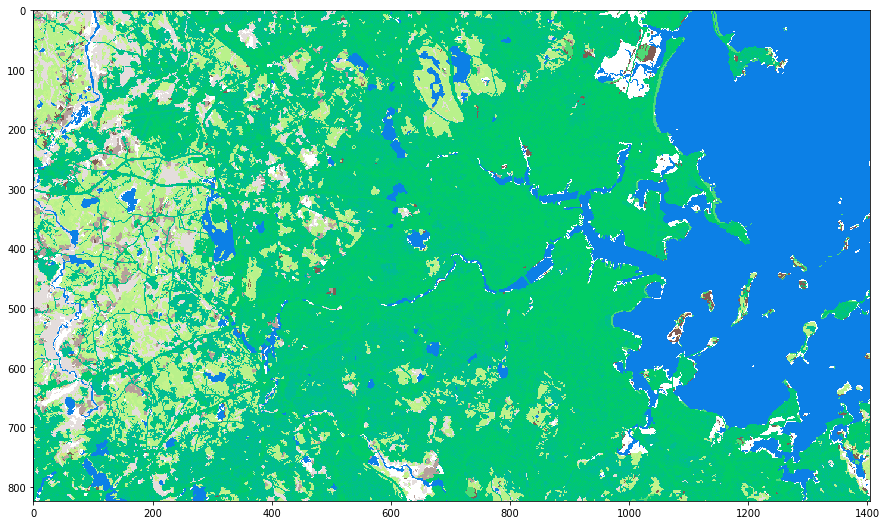

In [8]:
clip_img_open = rasterio.open(out_tif)
clip_img = clip_img_open.read()

plt.figure(figsize=(15,15))
show((clip_img), cmap='terrain')

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold">Image Statistics: </p>

Landsat image downloaded contains the Anderson landcover classess in the Continentatl United States. We can view the statistics of these classes in the Boston area

[{'min': 0, 'mean': 28.459440970182772, 'median': 23.0, 'max': 95}]
Total number of Anderson landcover classes present in the Boston area =  16
Landcover classes in the Boston area =  [ 0 11 21 22 23 24 31 41 42 43 52 71 81 82 90 95]


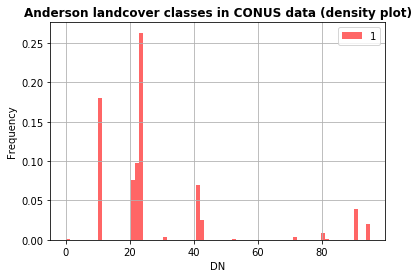

In [9]:
#Stats
stats = []
stats.append({
'min': clip_img.min(),
'mean': clip_img.mean(),
'median': np.median(clip_img),
'max': clip_img.max()})
print(stats)
print("Total number of Anderson landcover classes present in the Boston area = ",np.count_nonzero(np.unique(clip_img))+1)
print("Landcover classes in the Boston area = ",np.unique(clip_img))

#plt.figure(figsize=(5,5))
show_hist(clip_img, density = True, bins=75, alpha=0.6, title="Anderson landcover classes in CONUS data (density plot)")


<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold">Landcover classes in the Boston area: </p>

In [10]:
#Anderson Image Classification System Dictionary
ander = {
    "11" : "Open Water",
    "12" : "Perennial Ice/Snow",
    "21" : "Developed, Open Space",
    "22" : "Developed, Low Intensity",
    "23" : "Developed, Medium Intensity",
    "24" : "Developed, High Intensity",
    "31" : "Barren Land (Rock/Sand/Clay)",
    "41" : "Deciduous Forest",
    "42" : "Evergreen Forest",
    "43" : "Mixed Forest",
    "51" : "Dwarf Scrub",
    "52" : "Shrub/Scrub",
    "71" : "Grassland/Herbaceous",
    "72" : "Sedge/Herbaceous",
    "73" : "Lichens",
    "74" : "Moss",
    "81" : "Pasture/Hay",
    "82" : "Cultivated Crops",
    "90" : "Woody Wetlands",
    "95" : "Emergent Herbaceous Wetlands"
}

unique, counts = np.unique(clip_img, return_counts=True)
percent = counts*100/sum(counts)
np.set_printoptions(precision=2)

print("Land cover classes and percentage of area in Boston")
ander_list = []
for i, x in enumerate(unique):
    ander_list.append(ander.get(str(x)))

d = {'Class/Value' : unique, 'Landcover description' : ander_list, 'Percent area' : percent}
boston_stats = pd.DataFrame(data=d)
boston_stats.sort_values(by=['Percent area'], ascending = 0)


Land cover classes and percentage of area in Boston


,Class/Value,Landcover description,Percent area
1,11,Open Water,22.828663
4,23,"Developed, Medium Intensity",21.172822
3,22,"Developed, Low Intensity",12.326469
5,24,"Developed, High Intensity",12.136268
2,21,"Developed, Open Space",9.561207
7,41,Deciduous Forest,8.856373
14,90,Woody Wetlands,5.013648
8,42,Evergreen Forest,2.861659
15,95,Emergent Herbaceous Wetlands,2.572902
12,81,Pasture/Hay,1.093356


<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>
Where are the 'Evergreen forest' areas in Boston<p/>
<br/>
We can manipulate the pixel values to just show the 'developed, high intensity' areas in Boston.

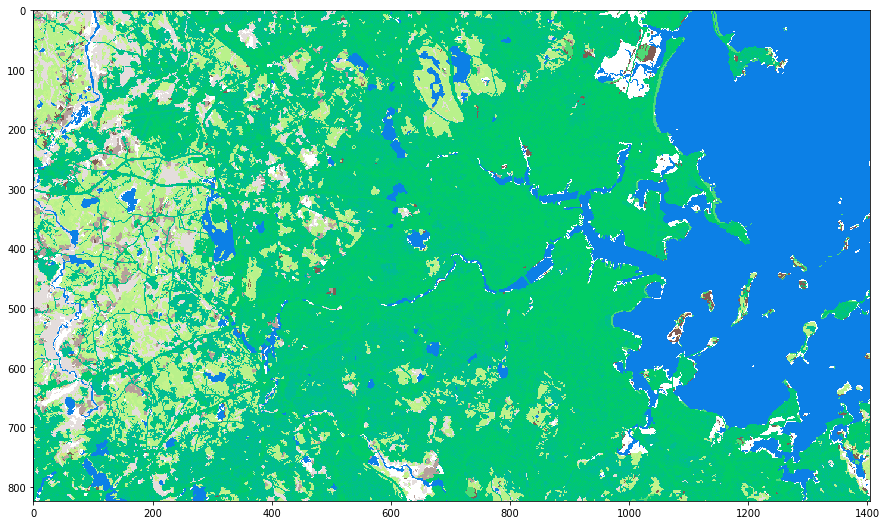

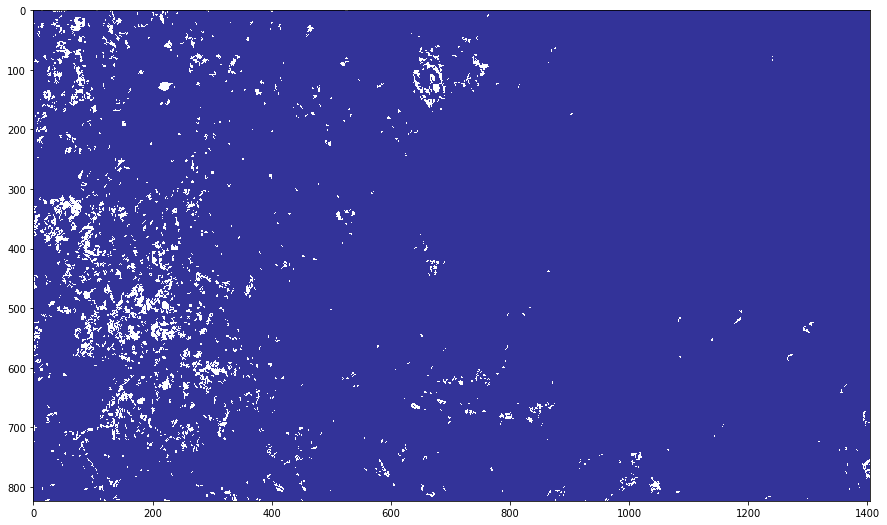

In [11]:
#Open and read the landsat image for the Boston area
clip_img_open = rasterio.open(out_tif)
clip_img = clip_img_open.read()

#View original landsat nlcd image for Boston
plt.figure(figsize=(15,15))
show(clip_img, cmap = 'terrain')

#Select Evergreen forest areas in Boston
forest_mask   = (clip_img != 42)
clip_img[forest_mask] = 0

#View Evergreen forest areas
plt.figure(figsize=(15,15))
show(clip_img, cmap = 'terrain')